# Pretrain MPNN using NWChem Atomization Energies
Use transfer learning from the Gaussian model to create an initial model for the atomization energy app.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from molgym.mpnn.data import convert_nx_to_dict, make_type_lookup_tables, make_tfrecord, make_data_loader
from molgym.utils.conversions import convert_smiles_to_nx
from molgym.mpnn.callbacks import LRLogger, EpochTimeLogger
from molgym.mpnn.layers import custom_objects
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

RDKit WARNING: [13:57:25] Enabling RDKit 2019.09.3 jupyter extensions


Configuration data

In [2]:
model_dir = os.path.join('..', '..', '..', 'notebooks', 'mpnn-atomization-energy')
assert os.path.isdir(model_dir)

## Load in the XTB Data
Make the training and validation data for the model

In [3]:
data = pd.read_csv('initial_nwchem.csv')

In [4]:
%%time
data['nx'] = data['smiles'].apply(lambda x: convert_smiles_to_nx(x, add_hs=True))

CPU times: user 352 ms, sys: 11.8 ms, total: 363 ms
Wall time: 362 ms


Save it in TF format

In [5]:
with open(os.path.join(model_dir, 'atom_types.json')) as fp:
    atom_types = json.load(fp)
with open('atom_types.json', 'w') as fp:
    json.dump(atom_types, fp)

In [6]:
with open(os.path.join(model_dir, 'bond_types.json')) as fp:
    bond_types = json.load(fp)
with open('bond_types.json', 'w') as fp:
    json.dump(bond_types, fp)

In [7]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=1)

In [8]:
train_set, val_set = train_test_split(train_set, test_size=0.1, random_state=1)

In [9]:
for name, dataset in zip(['train', 'valid', 'test'], [train_set, val_set, test_set]):
    dataset = dataset.sample(frac=1.)  # Shuffle contents
    with tf.io.TFRecordWriter(f'{name}_data.proto') as writer:
        for _, entry in tqdm(dataset.iterrows(), desc=name):
            record = convert_nx_to_dict(entry['nx'], atom_types, bond_types)
            for output in ['u_e_atom']:
                record[output] = entry[output]
            writer.write(make_tfrecord(record))

train: 659it [00:00, 2421.53it/s]
valid: 74it [00:00, 2371.06it/s]
test: 82it [00:00, 2294.46it/s]


## Train the Model
Use the model trained on the QM9 atomization energy

In [10]:
model = tf.keras.models.load_model(os.path.join(model_dir, 'best_model.h5'), custom_objects=custom_objects)

/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/co

In [11]:
with open(os.path.join(model_dir, 'best_config.json')) as fp:
    config = json.load(fp)

Make the data loaders

In [12]:
train_loader = make_data_loader('train_data.proto', shuffle_buffer=1024, batch_size=config['batch_size'], output_property='u_e_atom')

In [13]:
val_loader = make_data_loader('valid_data.proto', batch_size=config['batch_size'], output_property='u_e_atom')

In [14]:
test_loader = make_data_loader('test_data.proto', batch_size=config['batch_size'], output_property='u_e_atom')

Re-compile the model with a new optimizer

In [15]:
final_learn_rate = 1e-6
init_learn_rate = 1e-3
decay_rate = (final_learn_rate / init_learn_rate) ** (1. / (config['num_epochs'] - 1))

In [16]:
def lr_schedule(epoch, lr):
    return lr * decay_rate

In [17]:
cb = tf.keras.callbacks

In [18]:
model.compile(tf.keras.optimizers.Adam(init_learn_rate), 'mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(
    train_loader, validation_data=val_loader, epochs=config['num_epochs'], verbose=False,
    shuffle=False, callbacks=[
        LRLogger(),
        EpochTimeLogger(),
        cb.LearningRateScheduler(lr_schedule),
        cb.ModelCheckpoint('best_model.h5', save_best_only=True),
        cb.EarlyStopping(patience=128, restore_best_weights=True),
        cb.CSVLogger('train_log.csv'),
        cb.TerminateOnNaN()
    ]
)

/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/co

Plot the training performance

Text(0, 0.5, 'Loss (Ha$^2$)')

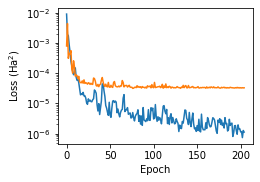

In [19]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogy(history.epoch, history.history['loss'], label='Train')
ax.semilogy(history.epoch, history.history['val_loss'], label='Validation')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Ha$^2$)')

## Assess Performance
Evaluate ht emodel performance

In [20]:
y_true = np.hstack([x[1].numpy()[:, 0] for x in iter(test_loader)])
y_pred = np.squeeze(model.predict(test_loader))

In [21]:
test_data = pd.DataFrame({'true': y_true, 'pred': y_pred})

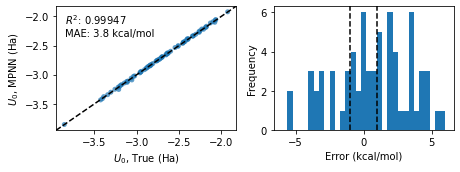

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

errors = (test_data['pred'] - test_data['true']) * 627.50947406  # kcal/mol
r2_score = np.corrcoef(test_data['pred'], test_data['true'])[0][1] ** 2

ax = axs[0]
ax.scatter(test_data['true'], test_data['pred'], s=25, alpha=0.7, edgecolor='none')
ax.text(0.05, 0.95, f'$R^2$:{r2_score: .5f}\nMAE:{errors.abs().mean(): .1f} kcal/mol', 
       transform=ax.transAxes, va='top', ha='left')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('$U_0$, True (Ha)')
ax.set_ylabel('$U_0$, MPNN (Ha)')

ax = axs[1]


ax.hist(errors, bins=np.linspace(-6, 6, 32))
ax.text(1, 0.95, f'', 
       transform=ax.transAxes, va='top', ha='right')

ax.set_ylim(ax.get_ylim())
ax.plot([-1, -1], ax.get_ylim(), 'k--')
ax.plot([1, 1], ax.get_ylim(), 'k--')

ax.set_xlabel('Error (kcal/mol)')
ax.set_ylabel('Frequency')
fig.tight_layout()